<a href="https://colab.research.google.com/github/AntonioAscue/CodingPrep/blob/master/GAN_syndata_7_2hr_Prediction_LSTM_exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICT 2 HOUR CARDIAC ARREST USING RNN LSTM

1. Input to this notebook - `mimic_iii_staging.vital_agg_columnar_fill_in_missing_hour`

2. RNN Architecture -

Input(examples,8 time steps,6 features)-> LSTM Layer 1(16 hidden units) -> LSTM Layer 2 (16 hidden units)-> FC(16 hidden units) -> Output

Adding synthetic data with GAN to test performance

PENDING:
1. ONE HOT ENCODING FOR CATEGORICAL VALUES
2. IMPUTE AGE , SOMETIME IT IS 0.


In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
%pip install pydata-google-auth
import pydata_google_auth
CREDENTIALS = pydata_google_auth.get_user_credentials( ['https://www.googleapis.com/auth/bigquery'], )
# project setup
import os
PROJECT = "pea-asystole"
REGION = "us-west1-b"
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT, credentials=CREDENTIALS)

# Create a BigQuery Client object.

bq = bigquery.Client(project=PROJECT, credentials=CREDENTIALS)

def qdf(query, client=bq):
    """
        A helper function for mapping queries to a dataframe.
        
        Parameters
        ----------
        query : string
            The SQL query for the database.
        
        client : bigquery.Client
            Client object to call.
        
        Returns
        -------
        pandas.DataFrame
            The result of the query.
    """
    return client.query(query).to_dataframe()

In [11]:
! pip install sdv
! pip install delayed

## **3 - SETUP TRAINING/VALIDATION/TESTING DATA**

In [19]:
# create train/test/val for 2 hour prediction
query = """
create or replace table `mimic_model_2hr.train_test_val_set_rnn`
as
select 
distinct
subject_id,
'test' as type
from mimic_model_2hr.time_series_8_hour_vitals_final f
join mimic_iii_staging.test_set t
on f.subject_id = t.int64_field_0
where ((f.patient_group = 'control') or (f.hours_before_cardiac_arrest = 2 and f.patient_group = 'case'))
"""
qdf(query)

# get the subject ids not in the test set
query = """
select 
distinct
subject_id,patient_group
from mimic_model_2hr.time_series_8_hour_vitals_final f
where subject_id not in (select distinct subject_id from `mimic_model_2hr.train_test_val_set_rnn`) """
training_set = qdf(query)


# split into train and validation set
def get_class_proportions(df):
  grp = df.groupby(['patient_group'])['subject_id'].nunique()
  class_counts = {key: grp[key] for key in list(grp.keys())}
  print("class counts",class_counts)
  return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

from sklearn.model_selection import train_test_split
train, test = train_test_split(training_set,test_size=0.10,stratify=training_set['patient_group'])
print("train size",train.shape)
print("test size",test.shape)
train['type'] = 'train'
test['type'] = 'val'
train_class_prop = get_class_proportions(train)
test_class_prop = get_class_proportions(test)

print('Train set',train_class_prop)
print('Test set',test_class_prop)

# remove labels
train.drop('patient_group', inplace=True, axis=1)
test.drop('patient_group', inplace=True, axis=1)

# upload the subject ids to google big query table
table_id = "pea-asystole.mimic_model_2hr.train_test_val_set_rnn"
job_config = bigquery.LoadJobConfig(
    schema=[
    bigquery.SchemaField("subject_id", bigquery.enums.SqlTypeNames.INTEGER),
    bigquery.SchemaField("type", bigquery.enums.SqlTypeNames.STRING),
    ],
)


## train set
job = client.load_table_from_dataframe(
    train, table_id, job_config=job_config
)
job.result()

table = client.get_table(table_id)  # Make an API request.

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

## validation set
job = client.load_table_from_dataframe(
    test, table_id, job_config=job_config
)
job.result()

table = client.get_table(table_id)  # Make an API request.

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)



train size (32236, 2)
test size (3582, 2)
class counts {'case': 441, 'control': 31795}
class counts {'case': 49, 'control': 3533}
Train set {'case': 0.0137, 'control': 0.9863}
Test set {'case': 0.0137, 'control': 0.9863}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Loaded 35850 rows and 2 columns to pea-asystole.mimic_model_2hr.train_test_val_set_rnn
Loaded 39432 rows and 2 columns to pea-asystole.mimic_model_2hr.train_test_val_set_rnn


In [20]:
# check the size of training,validation and test set

query = """
select type,count(1) as total  from mimic_model_2hr.train_test_val_set_rnn
group by type
"""
qdf(query)

,type,total
0,val,3582
1,test,3614
2,train,32236


In [21]:
# 4.2 get training data - keep the last row only

## Remove -- in the query below to get static features

query = """
select 
a.*,
case when a.patient_group = 'case' then 1 else 0 end as label,
t.type,
--f.age,
--f.ethnicity_grouped,
--f.gender
from mimic_model_2hr.features_timeseries_stg a
left join mimic_model_2hr.train_test_val_set_rnn t
on a.subject_id = t.subject_id
--left join mimic_iii_staging.patient_static_features f
--on a.subject_id = f.subject_id
where a.hour_from_intime  =
(select max(b.hour_from_intime) 
from mimic_model_2hr.features_timeseries_stg b where a.subject_id = b.subject_id and a.hadm_id = b.hadm_id and a.icustay_id = b.icustay_id)
"""
all_data_org = qdf(query)

print("Data shape",all_data_org.shape)
display(all_data_org.head())

# rearrange the columns
def reorder_columns(dataframe, col_name, position):
    temp_col = dataframe[col_name]
    dataframe = dataframe.drop(columns=[col_name])
    dataframe.insert(loc=position, column=col_name, value=temp_col)
    return dataframe


all_data_org = reorder_columns(dataframe=all_data_org, col_name='type', position=3)
all_data_org = reorder_columns(dataframe=all_data_org, col_name='label', position=3)
all_data_org = reorder_columns(dataframe=all_data_org, col_name='patient_group', position=3)
# all_data_org = reorder_columns(dataframe=all_data_org, col_name='gender', position=3)
# all_data_org = reorder_columns(dataframe=all_data_org, col_name='ethnicity_grouped', position=3)
# all_data_org = reorder_columns(dataframe=all_data_org, col_name='dob', position=3)
# all_data_org = reorder_columns(dataframe=all_data_org, col_name='admission_type', position=3)
# all_data_org = reorder_columns(dataframe=all_data_org, col_name='age', position=3)

display(all_data_org.head())
print("Shape",all_data_org.shape)

Data shape (39452, 61)


,icustay_id,subject_id,hadm_id,intime,outtime,patient_group,cardiac_arrest_time,hour_time,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature,label,type
0,223584,5044,186556,2118-08-05 01:38:00,2118-08-07 00:51:00,control,None,2118-08-06 18:00:00+00:00,NaN,40,62,12.000000,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.000000,52.0,63.0,14.0,94.571429,36.000001,0,train
1,228389,26222,120878,2114-11-06 13:44:23,2114-11-07 17:39:28,control,None,2114-11-07 14:00:00+00:00,NaN,24,39,10.470588,68.000000,117.000000,68.500000,94.000000,36.111105,20.0,95.000000,129.500000,90.500000,97.000000,36.111105,20.000000,95.000000,132.500000,60.500000,95.000000,36.111105,20.0,97.000000,124.000000,65.000000,96.000000,36.754382,10.470588,99.000000,138.000000,52.000000,96.000000,36.222210,10.470588,88.000000,131.000000,64.000000,97.000000,36.222210,10.470588,96.000000,132.000000,53.000000,96.000000,36.222210,10.470588,92.0,143.0,62.0,96.000000,36.754382,0,test
2,234244,2973,169192,2144-01-08 16:00:00,2144-01-12 15:23:00,control,None,2144-01-12 14:00:00+00:00,NaN,94,94,11.000000,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.000000,69.000000,140.000000,56.000000,98.000000,36.555578,10.000000,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.000000,69.0,128.5,53.0,97.000000,36.444422,0,train
3,237543,30882,132521,2105-09-13 14:33:25,2105-09-15 16:00:35,control,None,2105-09-15 13:00:00+00:00,NaN,46,72,19.000000,77.000000,134.000000,78.000000,95.000000,36.111105,19.0,83.000000,129.000000,88.000000,95.000000,36.111105,17.000000,72.000000,126.000000,92.000000,96.000000,36.111105,15.0,90.000000,117.000000,69.000000,96.000000,37.121618,17.500000,82.500000,132.000000,69.000000,95.000000,36.666683,16.000000,80.000000,119.000000,64.000000,94.000000,36.666683,18.000000,80.500000,126.000000,71.000000,93.000000,36.666683,14.000000,81.0,127.0,80.0,94.000000,37.121618,0,val
4,264705,11457,184929,2161-03-05 19:05:05,2161-03-06 16:34:33,control,None,2161-03-06 13:00:00+00:00,NaN,17,71,20.000000,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.000000,106.5,95.5,40.0,96.200000,36.870368,0,train


,icustay_id,subject_id,hadm_id,patient_group,label,type,intime,outtime,cardiac_arrest_time,hour_time,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,223584,5044,186556,control,0,train,2118-08-05 01:38:00,2118-08-07 00:51:00,None,2118-08-06 18:00:00+00:00,NaN,40,62,12.000000,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.000000,52.0,63.0,14.0,94.571429,36.000001
1,228389,26222,120878,control,0,test,2114-11-06 13:44:23,2114-11-07 17:39:28,None,2114-11-07 14:00:00+00:00,NaN,24,39,10.470588,68.000000,117.000000,68.500000,94.000000,36.111105,20.0,95.000000,129.500000,90.500000,97.000000,36.111105,20.000000,95.000000,132.500000,60.500000,95.000000,36.111105,20.0,97.000000,124.000000,65.000000,96.000000,36.754382,10.470588,99.000000,138.000000,52.000000,96.000000,36.222210,10.470588,88.000000,131.000000,64.000000,97.000000,36.222210,10.470588,96.000000,132.000000,53.000000,96.000000,36.222210,10.470588,92.0,143.0,62.0,96.000000,36.754382
2,234244,2973,169192,control,0,train,2144-01-08 16:00:00,2144-01-12 15:23:00,None,2144-01-12 14:00:00+00:00,NaN,94,94,11.000000,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.000000,69.000000,140.000000,56.000000,98.000000,36.555578,10.000000,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.000000,69.0,128.5,53.0,97.000000,36.444422
3,237543,30882,132521,control,0,val,2105-09-13 14:33:25,2105-09-15 16:00:35,None,2105-09-15 13:00:00+00:00,NaN,46,72,19.000000,77.000000,134.000000,78.000000,95.000000,36.111105,19.0,83.000000,129.000000,88.000000,95.000000,36.111105,17.000000,72.000000,126.000000,92.000000,96.000000,36.111105,15.0,90.000000,117.000000,69.000000,96.000000,37.121618,17.500000,82.500000,132.000000,69.000000,95.000000,36.666683,16.000000,80.000000,119.000000,64.000000,94.000000,36.666683,18.000000,80.500000,126.000000,71.000000,93.000000,36.666683,14.000000,81.0,127.0,80.0,94.000000,37.121618
4,264705,11457,184929,control,0,train,2161-03-05 19:05:05,2161-03-06 16:34:33,None,2161-03-06 13:00:00+00:00,NaN,17,71,20.000000,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.000000,106.5,95.5,40.0,96.200000,36.870368


Shape (39452, 61)


In [22]:
# 4.4 Train, Validation and Test set for Models

train     = all_data_org[(all_data_org['type'] == 'train')] 
val       = all_data_org[(all_data_org['type'] == 'val')] 
test      = all_data_org[(all_data_org['type'] == 'test')]

# print the size of each
print("Train",train.shape)
print("Validation",val.shape)
print("Test",test.shape)

# get the class distribution
print("Train Label Distribution\n",train.label.value_counts())
print("Validation Label Distribution\n",val.label.value_counts())
print("Test Label Distribution\n",test.label.value_counts())

# get the labels
y_train  = train['label']
y_val = val['label']
y_test  = test['label']


# replace nan with 0 (case patients dont have readings for all 8 hours otherwise oversample gives an error)
x_train = train.fillna(0)
x_val = val.fillna(0)
x_test = test.fillna(0)

#Not removed the first 13 column at once as the original notebook

Train (32252, 61)
Validation (3583, 61)
Test (3617, 61)
Train Label Distribution
 0    31796
1      456
Name: label, dtype: int64
Validation Label Distribution
 0    3533
1      50
Name: label, dtype: int64
Test Label Distribution
 0    3562
1      55
Name: label, dtype: int64


In [23]:
#Check the data sets before
display(x_train.head())
display(x_test.head())
display(x_val.head())

,icustay_id,subject_id,hadm_id,patient_group,label,type,intime,outtime,cardiac_arrest_time,hour_time,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,223584,5044,186556,control,0,train,2118-08-05 01:38:00,2118-08-07 00:51:00,0,2118-08-06 18:00:00+00:00,0.0,40,62,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.0,52.0,63.0,14.0,94.571429,36.000001
2,234244,2973,169192,control,0,train,2144-01-08 16:00:00,2144-01-12 15:23:00,0,2144-01-12 14:00:00+00:00,0.0,94,94,11.0,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.0,69.000000,140.000000,56.000000,98.000000,36.555578,10.0,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.0,69.0,128.5,53.0,97.000000,36.444422
4,264705,11457,184929,control,0,train,2161-03-05 19:05:05,2161-03-06 16:34:33,0,2161-03-06 13:00:00+00:00,0.0,17,71,20.0,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.0,106.5,95.5,40.0,96.200000,36.870368
5,275511,52261,154647,control,0,train,2148-04-04 17:56:08,2148-04-07 18:02:58,0,2148-04-07 13:00:00+00:00,0.0,67,70,26.0,91.000000,158.000000,90.000000,90.000000,37.000000,16.0,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.0,94.000000,152.000000,69.000000,91.000000,37.000000,25.0,88.000000,152.000000,69.000000,98.000000,37.000000,18.0,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.0,97.0,1.0,1.0,100.000000,37.000000
7,214122,63878,101540,control,0,train,2108-01-02 22:31:26,2108-01-04 10:57:52,0,2108-01-04 08:00:00+00:00,0.0,33,61,11.0,80.000000,138.000000,94.000000,97.000000,37.000000,12.0,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.0,83.000000,145.000000,106.000000,97.000000,37.000000,15.0,82.000000,152.000000,120.000000,94.000000,37.000000,13.0,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.0,100.0,147.0,88.0,94.000000,37.000000


,icustay_id,subject_id,hadm_id,patient_group,label,type,intime,outtime,cardiac_arrest_time,hour_time,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
1,228389,26222,120878,control,0,test,2114-11-06 13:44:23,2114-11-07 17:39:28,0,2114-11-07 14:00:00+00:00,0.0,24,39,10.470588,68.0,117.0,68.5,94.000000,36.111105,20.000000,95.00,129.5,90.5,97.000000,36.111105,20.000000,95.000000,132.500000,60.500000,95.000000,36.111105,20.00,97.0,124.0,65.0,96.0,36.754382,10.470588,99.0,138.0,52.0,96.0,36.222210,10.470588,88.0,131.0,64.0,97.0,36.222210,10.470588,96.0,132.00,53.00,96.0,36.222210,10.470588,92.0,143.0,62.0,96.000000,36.754382
23,265325,30408,134728,control,0,test,2148-11-08 08:23:44,2148-11-11 17:19:36,0,2148-11-11 14:00:00+00:00,0.0,77,113,16.000000,76.0,170.0,82.0,97.000000,37.166683,18.000000,77.00,172.0,84.0,97.000000,37.166683,19.000000,84.000000,185.000000,88.000000,98.000000,37.168523,23.00,73.0,173.0,85.0,97.0,36.666683,28.000000,99.0,181.0,88.0,97.0,36.666683,20.000000,93.0,175.0,82.0,97.0,36.666683,20.000000,91.0,180.00,82.00,96.0,37.168523,20.000000,91.0,180.0,81.0,96.000000,37.666683
32,222077,3099,192640,control,0,test,2103-07-04 18:19:00,2103-07-05 21:48:00,0,2103-07-05 16:00:00+00:00,0.0,21,62,13.000000,90.6,67.4,56.6,9.333333,36.020001,10.666667,91.75,73.5,61.0,9.333333,36.150000,0.750000,92.500000,64.200000,52.200000,50.500000,36.175001,0.75,90.0,68.8,55.0,50.5,36.225000,14.000000,76.0,66.5,57.0,4.0,36.075000,4.666667,64.5,67.0,47.4,4.0,36.075000,1.500000,73.0,50.75,44.25,4.0,35.725000,1.500000,21.0,37.0,32.0,37.029762,35.600000
34,243621,58781,170511,case,1,test,2167-11-13 11:08:32,2167-11-15 12:54:36,2167-11-14 17:11:00,2167-11-14 15:00:00+00:00,2.0,27,78,19.000000,62.0,141.0,39.0,99.000000,37.000000,17.000000,64.00,137.0,37.0,100.000000,37.000000,13.000000,63.000000,125.000000,38.000000,100.000000,37.000000,24.00,68.0,138.0,43.0,99.0,37.000000,21.000000,66.0,120.0,35.0,100.0,37.000000,17.000000,62.0,127.0,36.0,100.0,37.000000,17.000000,63.0,130.00,32.00,100.0,37.000000,20.000000,64.0,137.0,37.0,100.000000,37.000000
36,257694,6552,103859,control,0,test,2115-11-17 03:35:30,2115-11-22 17:45:45,0,2115-11-22 15:00:00+00:00,0.0,131,155,16.000000,49.0,96.0,48.0,98.000000,37.334908,16.000000,49.00,96.0,48.0,98.000000,37.334908,18.763021,63.873884,100.986559,49.672043,97.928013,37.334908,16.00,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,52.0,90.00,51.00,98.0,37.333317,16.000000,52.0,90.0,51.0,98.000000,37.333317


,icustay_id,subject_id,hadm_id,patient_group,label,type,intime,outtime,cardiac_arrest_time,hour_time,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
3,237543,30882,132521,control,0,val,2105-09-13 14:33:25,2105-09-15 16:00:35,0,2105-09-15 13:00:00+00:00,0.0,46,72,19.00000,77.0,134.0,78.0,95.0,36.111105,19.00000,83.0,129.0,88.0,95.0,36.111105,17.00000,72.0,126.000000,92.000000,96.000000,36.111105,15.00000,90.0,117.0,69.0,96.0,37.121618,17.50000,82.5,132.0,69.0,95.0,36.666683,16.00000,80.0,119.0,64.0,94.0,36.666683,18.00000,80.5,126.000000,71.000000,93.000,36.666683,14.0,81.0,127.0,80.0,94.0,37.121618
6,275780,68531,112561,control,0,val,2160-05-23 14:31:37,2160-05-24 16:51:07,0,2160-05-24 15:00:00+00:00,0.0,24,52,17.00000,127.0,121.5,74.0,99.0,37.000000,19.00000,119.0,119.5,64.5,100.0,37.000000,17.00000,119.0,107.000000,78.500000,96.000000,37.000000,20.00000,111.0,103.5,68.0,97.0,37.000000,17.00000,113.0,92.0,54.5,97.0,37.000000,21.00000,114.0,93.0,55.0,98.0,37.000000,19.00000,93.0,98.500000,60.000000,99.000,37.000000,25.0,100.0,114.0,57.0,95.0,37.000000
10,241839,7701,164574,control,0,val,2125-02-25 02:45:32,2125-03-19 17:36:28,0,2125-03-19 14:00:00+00:00,0.0,539,553,25.00000,88.0,120.0,45.0,96.0,37.944423,28.00000,87.0,119.0,45.0,96.0,37.944423,23.00000,78.0,113.000000,37.000000,97.000000,37.549095,22.00000,77.0,110.0,35.0,96.0,37.444423,23.00000,81.0,103.0,30.0,94.0,37.444423,16.00000,80.0,103.0,30.0,95.0,37.444423,26.00000,85.0,124.000000,48.000000,85.000,37.549095,19.0,83.0,116.0,45.0,98.0,37.166683
29,205287,26421,178445,control,0,val,2106-05-18 18:36:00,2106-05-20 01:56:00,0,2106-05-19 22:00:00+00:00,0.0,27,51,16.00000,106.0,123.0,76.0,95.0,37.444423,16.00000,102.0,123.0,76.0,95.0,37.444423,14.50000,102.0,118.589286,65.339286,94.285714,37.023141,14.50000,105.0,144.0,71.0,93.0,37.333317,14.50000,103.0,134.0,84.0,95.0,37.333317,14.50000,103.0,133.0,72.0,90.0,37.333317,14.50000,107.0,131.000000,73.000000,93.000,37.023141,14.5,106.0,140.0,85.0,92.0,37.023141
58,205986,21757,110733,control,0,val,2131-12-04 16:48:39,2131-12-06 20:46:20,0,2131-12-06 19:00:00+00:00,0.0,50,61,16.17165,103.0,120.0,68.0,98.0,36.722210,16.17165,79.0,120.0,68.0,98.0,36.722210,16.17165,79.0,112.753333,63.843704,99.075000,36.708334,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,93.0,139.0,74.0,99.0,37.333317,16.17165,93.0,112.753333,63.843704,99.075,36.708334,18.0,89.0,131.0,66.0,98.0,36.833318


In [24]:
# select the columns to be remove before synthetize data

col_remove = set(['icustay_id',	'subject_id',	'hadm_id',	'patient_group', 'type', 'intime',	'outtime',	'cardiac_arrest_time',	'hour_time'	])

#Remove the ten first columns except label

x_train.drop(col_remove, inplace=True, axis=1)
x_val.drop(col_remove, inplace=True, axis=1)
x_test.drop(col_remove, inplace=True, axis=1)

In [25]:
#Check data set after removal of columns
display(x_train.head())
display(x_test.head())
display(x_val.head())

,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,0,0.0,40,62,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.0,52.0,63.0,14.0,94.571429,36.000001
2,0,0.0,94,94,11.0,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.0,69.000000,140.000000,56.000000,98.000000,36.555578,10.0,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.0,69.0,128.5,53.0,97.000000,36.444422
4,0,0.0,17,71,20.0,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.0,106.5,95.5,40.0,96.200000,36.870368
5,0,0.0,67,70,26.0,91.000000,158.000000,90.000000,90.000000,37.000000,16.0,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.0,94.000000,152.000000,69.000000,91.000000,37.000000,25.0,88.000000,152.000000,69.000000,98.000000,37.000000,18.0,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.0,97.0,1.0,1.0,100.000000,37.000000
7,0,0.0,33,61,11.0,80.000000,138.000000,94.000000,97.000000,37.000000,12.0,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.0,83.000000,145.000000,106.000000,97.000000,37.000000,15.0,82.000000,152.000000,120.000000,94.000000,37.000000,13.0,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.0,100.0,147.0,88.0,94.000000,37.000000


,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
1,0,0.0,24,39,10.470588,68.0,117.0,68.5,94.000000,36.111105,20.000000,95.00,129.5,90.5,97.000000,36.111105,20.000000,95.000000,132.500000,60.500000,95.000000,36.111105,20.00,97.0,124.0,65.0,96.0,36.754382,10.470588,99.0,138.0,52.0,96.0,36.222210,10.470588,88.0,131.0,64.0,97.0,36.222210,10.470588,96.0,132.00,53.00,96.0,36.222210,10.470588,92.0,143.0,62.0,96.000000,36.754382
23,0,0.0,77,113,16.000000,76.0,170.0,82.0,97.000000,37.166683,18.000000,77.00,172.0,84.0,97.000000,37.166683,19.000000,84.000000,185.000000,88.000000,98.000000,37.168523,23.00,73.0,173.0,85.0,97.0,36.666683,28.000000,99.0,181.0,88.0,97.0,36.666683,20.000000,93.0,175.0,82.0,97.0,36.666683,20.000000,91.0,180.00,82.00,96.0,37.168523,20.000000,91.0,180.0,81.0,96.000000,37.666683
32,0,0.0,21,62,13.000000,90.6,67.4,56.6,9.333333,36.020001,10.666667,91.75,73.5,61.0,9.333333,36.150000,0.750000,92.500000,64.200000,52.200000,50.500000,36.175001,0.75,90.0,68.8,55.0,50.5,36.225000,14.000000,76.0,66.5,57.0,4.0,36.075000,4.666667,64.5,67.0,47.4,4.0,36.075000,1.500000,73.0,50.75,44.25,4.0,35.725000,1.500000,21.0,37.0,32.0,37.029762,35.600000
34,1,2.0,27,78,19.000000,62.0,141.0,39.0,99.000000,37.000000,17.000000,64.00,137.0,37.0,100.000000,37.000000,13.000000,63.000000,125.000000,38.000000,100.000000,37.000000,24.00,68.0,138.0,43.0,99.0,37.000000,21.000000,66.0,120.0,35.0,100.0,37.000000,17.000000,62.0,127.0,36.0,100.0,37.000000,17.000000,63.0,130.00,32.00,100.0,37.000000,20.000000,64.0,137.0,37.0,100.000000,37.000000
36,0,0.0,131,155,16.000000,49.0,96.0,48.0,98.000000,37.334908,16.000000,49.00,96.0,48.0,98.000000,37.334908,18.763021,63.873884,100.986559,49.672043,97.928013,37.334908,16.00,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,52.0,90.00,51.00,98.0,37.333317,16.000000,52.0,90.0,51.0,98.000000,37.333317


,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
3,0,0.0,46,72,19.00000,77.0,134.0,78.0,95.0,36.111105,19.00000,83.0,129.0,88.0,95.0,36.111105,17.00000,72.0,126.000000,92.000000,96.000000,36.111105,15.00000,90.0,117.0,69.0,96.0,37.121618,17.50000,82.5,132.0,69.0,95.0,36.666683,16.00000,80.0,119.0,64.0,94.0,36.666683,18.00000,80.5,126.000000,71.000000,93.000,36.666683,14.0,81.0,127.0,80.0,94.0,37.121618
6,0,0.0,24,52,17.00000,127.0,121.5,74.0,99.0,37.000000,19.00000,119.0,119.5,64.5,100.0,37.000000,17.00000,119.0,107.000000,78.500000,96.000000,37.000000,20.00000,111.0,103.5,68.0,97.0,37.000000,17.00000,113.0,92.0,54.5,97.0,37.000000,21.00000,114.0,93.0,55.0,98.0,37.000000,19.00000,93.0,98.500000,60.000000,99.000,37.000000,25.0,100.0,114.0,57.0,95.0,37.000000
10,0,0.0,539,553,25.00000,88.0,120.0,45.0,96.0,37.944423,28.00000,87.0,119.0,45.0,96.0,37.944423,23.00000,78.0,113.000000,37.000000,97.000000,37.549095,22.00000,77.0,110.0,35.0,96.0,37.444423,23.00000,81.0,103.0,30.0,94.0,37.444423,16.00000,80.0,103.0,30.0,95.0,37.444423,26.00000,85.0,124.000000,48.000000,85.000,37.549095,19.0,83.0,116.0,45.0,98.0,37.166683
29,0,0.0,27,51,16.00000,106.0,123.0,76.0,95.0,37.444423,16.00000,102.0,123.0,76.0,95.0,37.444423,14.50000,102.0,118.589286,65.339286,94.285714,37.023141,14.50000,105.0,144.0,71.0,93.0,37.333317,14.50000,103.0,134.0,84.0,95.0,37.333317,14.50000,103.0,133.0,72.0,90.0,37.333317,14.50000,107.0,131.000000,73.000000,93.000,37.023141,14.5,106.0,140.0,85.0,92.0,37.023141
58,0,0.0,50,61,16.17165,103.0,120.0,68.0,98.0,36.722210,16.17165,79.0,120.0,68.0,98.0,36.722210,16.17165,79.0,112.753333,63.843704,99.075000,36.708334,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,93.0,139.0,74.0,99.0,37.333317,16.17165,93.0,112.753333,63.843704,99.075,36.708334,18.0,89.0,131.0,66.0,98.0,36.833318


E: Unable to locate package delayed


In [27]:
# 5 GAN Synthetic Data Generation
from sdv.tabular import CTGAN

# Set up the GAN model
model = CTGAN()
model.fit(x_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit

In [21]:
display(x_train)

,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,0,0.0,130,172,28.0,128.0,78.0,34.0,89.0,36.834612,25.0,121.0,83.0,33.0,88.000000,36.834612,21.0,111.0,85.000000,26.000000,90.0,38.166682,21.0,111.0,85.0,26.0,90.0,38.166682,13.0,99.0,72.0,27.0,90.000000,38.166682,13.0,100.0,69.0,25.0,91.0,36.834612,14.0,67.0,72.0,14.0,91.0,36.834612,11.0,25.0,29.0,10.0,76.0,36.834612
2,0,0.0,46,99,29.0,97.0,135.0,59.0,95.0,36.388895,37.0,96.0,133.5,55.0,94.000000,36.388895,37.0,96.0,133.500000,55.000000,94.0,36.388895,29.0,97.0,135.5,61.5,96.0,37.344077,17.0,99.0,142.0,62.0,96.000000,37.344077,32.0,101.0,135.0,59.0,96.0,36.888895,28.0,76.0,102.0,52.0,95.0,36.888895,28.0,76.0,102.0,52.0,95.0,36.888895
3,0,0.0,42,74,11.0,69.0,129.0,54.0,98.0,36.557140,19.0,72.0,120.0,47.0,100.000000,36.222210,11.0,69.0,113.333333,45.666667,97.0,36.222210,11.0,63.0,109.0,37.0,100.0,36.222210,14.0,65.0,103.0,47.0,99.000000,36.557140,10.0,64.0,114.0,42.0,99.0,36.557140,18.0,66.0,112.0,53.0,99.0,36.557140,10.0,64.0,117.0,49.0,98.0,36.557140
4,0,0.0,697,746,32.0,69.0,100.0,38.0,99.0,36.000001,36.0,72.0,109.0,45.0,99.000000,36.000001,31.0,78.0,104.000000,37.000000,99.0,37.463766,35.0,74.0,111.0,37.0,100.0,36.888895,29.0,71.0,117.0,40.0,99.000000,36.888895,32.0,70.0,109.5,32.5,99.0,36.888895,28.0,67.0,114.0,39.0,99.0,37.463766,26.0,68.0,116.0,34.0,99.0,37.463766
5,0,0.0,202,261,23.0,95.0,73.0,54.0,98.0,35.833317,22.0,94.0,77.0,59.5,98.333333,35.833317,14.0,93.0,80.000000,57.000000,99.0,35.777790,22.0,93.0,83.5,56.5,100.0,35.777790,20.0,94.0,75.0,49.0,99.333333,35.777790,23.0,97.0,73.0,53.0,98.0,36.961113,24.0,96.0,60.0,42.0,98.0,36.961113,21.0,93.0,45.0,33.0,98.0,36.961113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39447,0,0.0,20,43,24.0,77.0,169.0,93.0,97.0,37.000000,25.0,74.0,152.0,79.0,97.000000,37.000000,27.0,74.0,169.000000,98.000000,100.0,37.000000,29.0,75.0,155.0,87.0,98.0,37.000000,26.0,74.0,154.0,86.0,98.000000,37.000000,32.0,82.0,157.0,90.0,95.0,37.000000,23.0,92.0,159.0,88.0,97.0,37.000000,27.0,85.0,134.0,77.0,96.0,37.000000
39448,0,0.0,92,130,24.0,107.0,121.0,70.0,100.0,36.166682,23.0,96.0,124.0,84.0,100.000000,36.166682,22.0,109.0,122.000000,78.000000,100.0,36.166682,22.0,106.0,130.0,87.0,97.0,36.915126,26.0,108.0,126.0,84.0,100.000000,36.388895,20.0,103.0,114.0,63.0,100.0,36.388895,21.0,98.0,120.0,78.0,100.0,36.388895,24.0,101.0,120.0,78.0,100.0,36.915126
39449,0,0.0,48,107,29.0,105.0,101.5,76.0,99.0,37.000000,14.0,95.0,98.0,72.0,100.000000,37.000000,16.0,102.0,122.000000,74.000000,100.0,37.000000,20.0,102.0,101.0,87.0,99.0,37.000000,23.0,101.0,98.0,68.0,100.000000,37.000000,15.0,94.0,98.0,68.0,100.0,37.000000,16.0,102.0,111.0,72.0,100.0,37.000000,16.0,102.0,114.0,75.0,100.0,37.000000
39450,0,0.0,34,53,21.0,105.0,138.0,64.0,100.0,37.166683,22.0,105.0,149.0,71.0,100.000000,37.166683,29.0,107.0,129.000000,66.000000,100.0,37.166683,24.0,110.0,157.0,87.0,100.0,36.910721,25.0,105.0,143.0,65.0,96.000000,37.166683,21.0,97.0,132.0,6

In [29]:
# Generate only samples where label == 1
conditions = {
'label': 1
}



In [30]:
x_train_GAN = model.sample(31495, conditions = conditions)

In [31]:
display(x_train_GAN.label.value_counts())
display(x_train_GAN.head())


1    31495
Name: label, dtype: int64

,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,1,2.0,3239,34,19.049096,87.759813,183.444454,46.756986,92.440150,35.719627,19.346934,79.675340,0.729543,75.175645,97.252856,36.763965,17.311574,169.020276,117.083568,76.297162,95.521643,35.736329,11.643657,95.013260,138.079674,21.047453,90.340601,37.880301,20.612936,84.978067,170.414045,53.757502,95.721828,35.832882,24.809796,115.107433,109.917478,73.018745,96.381032,37.253536,22.594332,91.752279,90.307427,58.570274,100.000000,37.357320,44.079263,85.383224,142.807117,127.368104,90.285281,36.148887
1,1,0.0,9,3,2.397343,160.823086,0.000000,16.795609,84.365630,35.806983,22.435479,73.671886,137.000877,90.322925,92.473698,37.009251,6.392713,122.447777,102.998524,66.681495,96.280829,37.007192,31.067428,98.676775,119.519923,70.294333,96.542348,37.233341,18.876093,94.063725,161.805209,57.342476,89.703799,36.836635,34.365243,119.184236,121.289624,25.603103,90.772379,39.162090,13.402670,147.600136,130.289752,65.717228,99.680901,37.172547,22.567112,66.826489,65.308541,49.391226,94.842090,36.256690
2,1,2.0,1864,-59,18.992550,130.032306,118.136125,16.847269,95.902639,35.529810,12.468346,122.181570,125.557708,0.000000,100.000000,36.072402,12.306240,94.954762,114.292810,110.825990,94.368890,9.721294,15.531988,163.818811,122.379657,63.515207,100.000000,36.929994,11.976227,94.660027,83.337234,61.471136,92.528865,35.614887,13.528744,144.224896,38.290300,114.478961,90.080340,37.619245,42.240164,91.868065,151.795768,77.344683,100.000000,37.146469,19.717618,90.730860,83.670331,48.743680,100.000000,34.976744
3,1,0.0,-5,291,7.362480,76.552626,106.568017,50.703887,96.316624,36.066714,37.196628,125.237511,138.092526,57.067068,91.008840,36.283677,6.589381,76.945168,96.161147,51.295048,94.872229,36.498463,22.971035,56.661692,74.101637,73.628182,91.430753,36.227049,20.177138,96.464173,126.848754,58.392461,68.578624,36.681386,14.347091,59.578528,75.880711,44.672197,96.323528,37.021049,10.940569,88.936825,91.809620,54.273859,95.729367,38.056696,38.718644,95.387420,63.417676,47.428031,90.581946,36.927552
4,1,0.0,1545,332,19.191585,83.941214,124.495924,73.909035,90.779797,41.000000,11.749299,10.931963,109.176356,76.123644,97.550640,2.369004,18.380186,97.661387,181.173916,54.134602,95.324770,36.749933,37.402414,72.411280,178.581238,59.484820,26.944089,34.857880,23.141834,84.428060,142.212411,54.089409,84.542024,38.552583,20.118186,120.344236,138.880025,75.584387,88.519024,37.000540,28.236774,200.306238,108.968666,77.290369,93.627194,36.539172,18.572763,122.188206,122.205964,72.436882,99.619125,37.010683


In [32]:
#Add the new generated label to a concat label and feature sets

train_y_concat = pd.concat([x_train['label'], x_train_GAN['label']])
train_x_concat = pd.concat([x_train.drop('label', axis=1), x_train_GAN.drop('label', axis=1)])
#Remove label column
#concat_df = pd.concat([x_train.iloc[:, :-1], x_train_GAN.iloc[:, :-1]])

In [33]:
#Observe the new concat label data set
display(train_x_concat.shape)
display(train_y_concat.shape)
display(train_y_concat.head())


(63747, 51)

(63747,)

0    0
2    0
4    0
5    0
7    0
Name: label, dtype: int64

In [34]:
display(train_x_concat.value_counts())
display(train_x_concat.head())

hours_before_cardiac_arrest  hour_from_intime  day_hour_min  imp_rr_prev_7  imp_hr_prev_7  imp_sys_bp_prev_7  imp_ds_bp_prev_7  imp_oxy_sat_prev_7  imp_temperature_prev_7  imp_rr_prev_6  imp_hr_prev_6  imp_sys_bp_prev_6  imp_ds_bp_prev_6  imp_oxy_sat_prev_6  imp_temperature_prev_6  imp_rr_prev_5  imp_hr_prev_5  imp_sys_bp_prev_5  imp_ds_bp_prev_5  imp_oxy_sat_prev_5  imp_temperature_prev_5  imp_rr_prev_4  imp_hr_prev_4  imp_sys_bp_prev_4  imp_ds_bp_prev_4  imp_oxy_sat_prev_4  imp_temperature_prev_4  imp_rr_prev_3  imp_hr_prev_3  imp_sys_bp_prev_3  imp_ds_bp_prev_3  imp_oxy_sat_prev_3  imp_temperature_prev_3  imp_rr_prev_2  imp_hr_prev_2  imp_sys_bp_prev_2  imp_ds_bp_prev_2  imp_oxy_sat_prev_2  imp_temperature_prev_2  imp_rr_prev_1  imp_hr_prev_1  imp_sys_bp_prev_1  imp_ds_bp_prev_1  imp_oxy_sat_prev_1  imp_temperature_prev_1  imp_respiratory_rate  imp_heart_rate  imp_systolic_blood_pressure  imp_diastolic_blood_pressure  imp_oxygen_saturation  imp_temperature
0.0                       

,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,0.0,40,62,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.0,52.0,63.0,14.0,94.571429,36.000001
2,0.0,94,94,11.0,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.0,69.000000,140.000000,56.000000,98.000000,36.555578,10.0,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.0,69.0,128.5,53.0,97.000000,36.444422
4,0.0,17,71,20.0,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.0,106.5,95.5,40.0,96.200000,36.870368
5,0.0,67,70,26.0,91.000000,158.000000,90.000000,90.000000,37.000000,16.0,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.0,94.000000,152.000000,69.000000,91.000000,37.000000,25.0,88.000000,152.000000,69.000000,98.000000,37.000000,18.0,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.0,97.0,1.0,1.0,100.000000,37.000000
7,0.0,33,61,11.0,80.000000,138.000000,94.000000,97.000000,37.000000,12.0,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.0,83.000000,145.000000,106.000000,97.000000,37.000000,15.0,82.000000,152.000000,120.000000,94.000000,37.000000,13.0,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.0,100.0,147.0,88.0,94.000000,37.000000


In [36]:
#Remove label the three columns for new train_x_new 
#Remove four columns for test and val feature

train_x_ctgan = train_x_concat.iloc[:,3:]
x_val = x_val.iloc[:,4:]
x_test = x_test.iloc[:,4:]

display(train_x_ctgan.shape)
display(train_x_ctgan)
display(x_val)
display(x_test.shape)
display(x_test)

(63747, 48)

,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,12.000000,95.666667,111.692308,49.769231,94.571429,37.250013,12.000000,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,10.000000,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.000000,52.000000,63.000000,14.000000,94.571429,36.000001
2,11.000000,76.000000,169.000000,62.000000,98.000000,36.666683,17.000000,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.000000,68.000000,122.000000,45.000000,98.000000,36.555578,9.000000,69.000000,140.000000,56.000000,98.000000,36.555578,10.000000,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.000000,69.000000,128.500000,53.000000,97.000000,36.444422
4,20.000000,101.000000,85.000000,35.000000,96.000000,36.888895,20.000000,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.000000,109.000000,88.000000,27.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,97.000000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.000000,106.500000,95.500000,40.000000,96.200000,36.870368
5,26.000000,91.000000,158.000000,90.000000,90.000000,37.000000,16.000000,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.000000,94.000000,152.000000,69.000000,91.000000,37.000000,25.000000,88.000000,152.000000,69.000000,98.000000,37.000000,18.000000,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.000000,97.000000,1.000000,1.000000,100.000000,37.000000
7,11.000000,80.000000,138.000000,94.000000,97.000000,37.000000,12.000000,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.000000,83.000000,145.000000,106.000000,97.000000,37.000000,15.000000,82.000000,152.000000,120.000000,94.000000,37.000000,13.000000,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.000000,100.000000,147.000000,88.000000,94.000000,37.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31490,3.581206,76.469481,80.841154,36.792667,98.339969,36.910969,17.629656,76.118770,93.456174,45.342382,99.703118,36.896496,11.050074,167.160327,122.545810,44.291308,97.978015,33.636655,17.267082,131.042072,123.555669,75.475145,99.905720,40.063431,47.773246,176.997245,125.087635,75.933700,97.409779,40.134213,10.339238,68.299575,89.657617,18.340891,93.441430,37.017826,1.370395,45.269472,123.174655,69.902853,100.000000,37.330692,20.875499,128.927342,56.341843,35.123296,94.429739,39.8476

,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
3,19.00000,77.0,134.0,78.0,95.0,36.111105,19.00000,83.0,129.0,88.0,95.0,36.111105,17.00000,72.0,126.000000,92.000000,96.000000,36.111105,15.00000,90.0,117.0,69.0,96.0,37.121618,17.50000,82.5,132.0,69.0,95.0,36.666683,16.00000,80.0,119.0,64.0,94.0,36.666683,18.00000,80.5,126.000000,71.000000,93.000,36.666683,14.0,81.0,127.0,80.0,94.0,37.121618
6,17.00000,127.0,121.5,74.0,99.0,37.000000,19.00000,119.0,119.5,64.5,100.0,37.000000,17.00000,119.0,107.000000,78.500000,96.000000,37.000000,20.00000,111.0,103.5,68.0,97.0,37.000000,17.00000,113.0,92.0,54.5,97.0,37.000000,21.00000,114.0,93.0,55.0,98.0,37.000000,19.00000,93.0,98.500000,60.000000,99.000,37.000000,25.0,100.0,114.0,57.0,95.0,37.000000
10,25.00000,88.0,120.0,45.0,96.0,37.944423,28.00000,87.0,119.0,45.0,96.0,37.944423,23.00000,78.0,113.000000,37.000000,97.000000,37.549095,22.00000,77.0,110.0,35.0,96.0,37.444423,23.00000,81.0,103.0,30.0,94.0,37.444423,16.00000,80.0,103.0,30.0,95.0,37.444423,26.00000,85.0,124.000000,48.000000,85.000,37.549095,19.0,83.0,116.0,45.0,98.0,37.166683
29,16.00000,106.0,123.0,76.0,95.0,37.444423,16.00000,102.0,123.0,76.0,95.0,37.444423,14.50000,102.0,118.589286,65.339286,94.285714,37.023141,14.50000,105.0,144.0,71.0,93.0,37.333317,14.50000,103.0,134.0,84.0,95.0,37.333317,14.50000,103.0,133.0,72.0,90.0,37.333317,14.50000,107.0,131.000000,73.000000,93.000,37.023141,14.5,106.0,140.0,85.0,92.0,37.023141
58,16.17165,103.0,120.0,68.0,98.0,36.722210,16.17165,79.0,120.0,68.0,98.0,36.722210,16.17165,79.0,112.753333,63.843704,99.075000,36.708334,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,75.0,139.0,74.0,99.0,37.333317,16.17165,93.0,139.0,74.0,99.0,37.333317,16.17165,93.0,112.753333,63.843704,99.075,36.708334,18.0,89.0,131.0,66.0,98.0,36.833318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39436,26.00000,83.0,123.0,71.0,98.0,37.000000,23.00000,78.0,95.0,58.0,97.0,37.000000,21.00000,74.0,120.000000,87.000000,95.000000,37.000000,23.00000,71.0,117.0,85.0,97.0,37.000000,25.00000,81.0,133.0,92.0,99.0,37.000000,21.00000,78.0,133.0,92.0,95.0,37.000000,25.00000,76.0,124.000000,98.000000,96.000,37.000000,24.0,80.0,115.0,66.0,96.0,37.000000
39440,26.00000,82.0,166.0,79.0,99.0,37.000000,25.00000,104.0,169.0,84.0,94.0,37.000000,24.00000,88.0,107.000000,87.000000,95.000000,37.000000,21.00000,102.0,161.0,75.0,99.0,37.000000,23.00000,80.0,161.0,75.0,100.0,37.000000,16.00000,79.0,121.0,67.0,100.0,37.000000,22.00000,73.0,144.000000,75.000000,100.000,37.000000,27.0,103.0,142.0,88.0,98.0,37.000000
39443,36.00000,63.0,160.0,66.0,98.0,37.000000,21.00000,64.0,160.0,66.0,99.0,37.000000,32.00000,95.0,137.000000,87.000000,100.000000,37.000000,20.00000,57.0,152.0,58.5,100.0,37.000000,20.00000,62.0,146.0,65.0,99.0,37.000000,25.00000,81.0,174.0,57.0,100.0,37.000000,30.00000,66.0,154.000000,90.000000,99.000,37.000000,19.0,70.0,169.0,66.0,100.0,37.000000
39445,31.00000,103.0,154.5,94.5,96.0,38.111105,31.00000,99.0,151.5,93.0,96.0,37.833317,28.00000,98.0,152.500000,87.000000,96.000000,37.8333

(3617, 48)

,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
1,10.470588,68.000000,117.0,68.5,94.000000,36.111105,20.000000,95.00,129.5,90.5,97.000000,36.111105,20.000000,95.000000,132.500000,60.500000,95.000000,36.111105,20.00,97.0,124.0,65.0,96.0,36.754382,10.470588,99.0,138.0,52.0,96.0,36.222210,10.470588,88.0,131.0,64.0,97.0,36.222210,10.470588,96.0,132.00,53.00,96.0,36.222210,10.470588,92.0,143.000000,62.000000,96.000000,36.754382
23,16.000000,76.000000,170.0,82.0,97.000000,37.166683,18.000000,77.00,172.0,84.0,97.000000,37.166683,19.000000,84.000000,185.000000,88.000000,98.000000,37.168523,23.00,73.0,173.0,85.0,97.0,36.666683,28.000000,99.0,181.0,88.0,97.0,36.666683,20.000000,93.0,175.0,82.0,97.0,36.666683,20.000000,91.0,180.00,82.00,96.0,37.168523,20.000000,91.0,180.000000,81.000000,96.000000,37.666683
32,13.000000,90.600000,67.4,56.6,9.333333,36.020001,10.666667,91.75,73.5,61.0,9.333333,36.150000,0.750000,92.500000,64.200000,52.200000,50.500000,36.175001,0.75,90.0,68.8,55.0,50.5,36.225000,14.000000,76.0,66.5,57.0,4.0,36.075000,4.666667,64.5,67.0,47.4,4.0,36.075000,1.500000,73.0,50.75,44.25,4.0,35.725000,1.500000,21.0,37.000000,32.000000,37.029762,35.600000
34,19.000000,62.000000,141.0,39.0,99.000000,37.000000,17.000000,64.00,137.0,37.0,100.000000,37.000000,13.000000,63.000000,125.000000,38.000000,100.000000,37.000000,24.00,68.0,138.0,43.0,99.0,37.000000,21.000000,66.0,120.0,35.0,100.0,37.000000,17.000000,62.0,127.0,36.0,100.0,37.000000,17.000000,63.0,130.00,32.00,100.0,37.000000,20.000000,64.0,137.000000,37.000000,100.000000,37.000000
36,16.000000,49.000000,96.0,48.0,98.000000,37.334908,16.000000,49.00,96.0,48.0,98.000000,37.334908,18.763021,63.873884,100.986559,49.672043,97.928013,37.334908,16.00,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,48.0,96.0,42.0,100.0,36.666683,16.000000,52.0,90.00,51.00,98.0,37.333317,16.000000,52.0,90.000000,51.000000,98.000000,37.333317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39417,15.975397,69.188994,153.0,63.0,96.000000,36.491766,15.975397,85.00,187.0,91.0,94.000000,36.333318,21.000000,73.000000,169.000000,87.000000,90.000000,36.333318,18.00,80.0,169.0,87.0,93.0,36.333318,19.000000,70.0,114.0,77.0,92.0,37.000000,19.000000,65.0,114.0,77.0,93.0,37.000000,16.000000,60.0,114.00,77.00,93.0,37.000000,16.000000,69.0,143.943827,62.393827,93.000000,36.491766
39431,16.000000,97.000000,163.0,119.0,97.000000,37.000000,17.000000,97.00,143.0,84.0,94.000000,37.000000,17.000000,91.000000,140.000000,87.000000,94.000000,37.000000,16.00,74.0,133.0,69.0,97.0,37.000000,12.000000,113.0,127.0,59.0,95.0,37.000000,16.000000,94.0,141.0,82.0,98.0,37.000000,21.000000,79.0,155.00,103.00,99.0,37.000000,10.000000,124.0,118.000000,81.000000,98.000000,37.000000
39432,18.000000,103.000000,144.0,91.0,96.000000,36.666683,18.000000,103.00,144.0,91.0,96.000000,36.619051,22.000000,110.000000,137.000000,87.000000,96.000000,37.277789,22.00,109.0,124.0,73.0,97.0,37.277789,20.000000,109.0,133.0,73.0,97.0,37.277789,21.000000,106.0,133.0,73.0,95.0,36.6

#### Reproduce the original synthetic data approach

In [38]:
# print the size of each
print("Train",train.shape)
print("Validation",val.shape)
print("Test",test.shape)

print('x_train',x_train.shape)
print('train_x_new',train_x_ctgan.shape)

display(x_train)

Train (32252, 61)
Validation (3583, 61)
Test (3617, 61)
x_train (32252, 52)
train_x_new (63747, 48)


,label,hours_before_cardiac_arrest,hour_from_intime,day_hour_min,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,0,0.0,40,62,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.0,52.0,63.0,14.0,94.571429,36.000001
2,0,0.0,94,94,11.0,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.0,69.000000,140.000000,56.000000,98.000000,36.555578,10.0,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.0,69.0,128.5,53.0,97.000000,36.444422
4,0,0.0,17,71,20.0,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.0,106.5,95.5,40.0,96.200000,36.870368
5,0,0.0,67,70,26.0,91.000000,158.000000,90.000000,90.000000,37.000000,16.0,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.0,94.000000,152.000000,69.000000,91.000000,37.000000,25.0,88.000000,152.000000,69.000000,98.000000,37.000000,18.0,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.0,97.0,1.0,1.0,100.000000,37.000000
7,0,0.0,33,61,11.0,80.000000,138.000000,94.000000,97.000000,37.000000,12.0,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.0,83.000000,145.000000,106.000000,97.000000,37.000000,15.0,82.000000,152.000000,120.000000,94.000000,37.000000,13.0,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.0,100.0,147.0,88.0,94.000000,37.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39442,0,0.0,17,49,18.0,88.000000,128.000000,67.000000,95.000000,37.055577,23.0,95.000000,128.000000,75.000000,96.000000,37.000000,16.000000,90.000000,158.000000,87.000000,97.000000,37.000000,16.0,79.000000,159.000000,80.000000,95.000000,37.000000,21.0,91.000000,132.000000,71.000000,96.000000,36.897441,19.0,89.000000,132.000000,71.000000,98.000000,36.897441,16.000000,83.000000,132.000000,71.000000,96.000000,36.897441,20.0,90.0,141.0,73.0,97.000000,37.388896
39446,0,0.0,20,29,33.0,103.000000,118.000000,76.000000,94.000000,37.000000,34.0,96.000000,113.000000,81.000000,95.

In [39]:
#Remove columns to for the x_train to be as the original notebook and the same
x_train_ori = x_train.iloc[:,4:] 
display(x_train_ori.shape)
display(x_train_ori)

(32252, 48)

,imp_rr_prev_7,imp_hr_prev_7,imp_sys_bp_prev_7,imp_ds_bp_prev_7,imp_oxy_sat_prev_7,imp_temperature_prev_7,imp_rr_prev_6,imp_hr_prev_6,imp_sys_bp_prev_6,imp_ds_bp_prev_6,imp_oxy_sat_prev_6,imp_temperature_prev_6,imp_rr_prev_5,imp_hr_prev_5,imp_sys_bp_prev_5,imp_ds_bp_prev_5,imp_oxy_sat_prev_5,imp_temperature_prev_5,imp_rr_prev_4,imp_hr_prev_4,imp_sys_bp_prev_4,imp_ds_bp_prev_4,imp_oxy_sat_prev_4,imp_temperature_prev_4,imp_rr_prev_3,imp_hr_prev_3,imp_sys_bp_prev_3,imp_ds_bp_prev_3,imp_oxy_sat_prev_3,imp_temperature_prev_3,imp_rr_prev_2,imp_hr_prev_2,imp_sys_bp_prev_2,imp_ds_bp_prev_2,imp_oxy_sat_prev_2,imp_temperature_prev_2,imp_rr_prev_1,imp_hr_prev_1,imp_sys_bp_prev_1,imp_ds_bp_prev_1,imp_oxy_sat_prev_1,imp_temperature_prev_1,imp_respiratory_rate,imp_heart_rate,imp_systolic_blood_pressure,imp_diastolic_blood_pressure,imp_oxygen_saturation,imp_temperature
0,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,12.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,10.0,95.666667,111.692308,49.769231,94.571429,37.250013,11.846154,95.666667,111.692308,49.769231,94.571429,37.250013,16.0,52.0,63.0,14.0,94.571429,36.000001
2,11.0,76.000000,169.000000,62.000000,98.000000,36.666683,17.0,80.000000,188.000000,68.000000,98.000000,36.610172,20.000000,83.000000,110.000000,38.000000,98.000000,36.555578,9.0,68.000000,122.000000,45.000000,98.000000,36.555578,9.0,69.000000,140.000000,56.000000,98.000000,36.555578,10.0,70.000000,160.000000,59.000000,97.000000,36.444422,22.000000,72.000000,173.000000,66.000000,97.000000,36.444422,13.0,69.0,128.5,53.0,97.000000,36.444422
4,20.0,101.000000,85.000000,35.000000,96.000000,36.888895,20.0,105.000000,85.000000,35.000000,96.000000,36.888895,20.000000,115.000000,88.000000,27.000000,97.000000,36.888895,21.0,109.000000,88.000000,27.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,97.000000,36.870368,15.0,94.000000,80.000000,29.000000,96.200000,36.870368,15.000000,94.000000,80.000000,29.000000,96.200000,36.870368,17.0,106.5,95.5,40.0,96.200000,36.870368
5,26.0,91.000000,158.000000,90.000000,90.000000,37.000000,16.0,96.000000,158.000000,90.000000,93.000000,37.000000,25.000000,96.000000,158.000000,90.000000,93.000000,37.000000,24.0,94.000000,152.000000,69.000000,91.000000,37.000000,25.0,88.000000,152.000000,69.000000,98.000000,37.000000,18.0,91.000000,149.000000,80.000000,94.000000,37.000000,23.000000,101.000000,149.000000,80.000000,94.000000,37.000000,21.0,97.0,1.0,1.0,100.000000,37.000000
7,11.0,80.000000,138.000000,94.000000,97.000000,37.000000,12.0,83.000000,133.000000,92.000000,98.000000,37.000000,12.000000,86.000000,118.000000,89.000000,95.000000,37.000000,15.0,83.000000,145.000000,106.000000,97.000000,37.000000,15.0,82.000000,152.000000,120.000000,94.000000,37.000000,13.0,87.000000,158.000000,106.000000,92.000000,37.000000,21.000000,96.000000,147.000000,88.000000,94.000000,37.000000,17.0,100.0,147.0,88.0,94.000000,37.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39442,18.0,88.000000,128.000000,67.000000,95.000000,37.055577,23.0,95.000000,128.000000,75.000000,96.000000,37.000000,16.000000,90.000000,158.000000,87.000000,97.000000,37.000000,16.0,79.000000,159.000000,80.000000,95.000000,37.000000,21.0,91.000000,132.000000,71.000000,96.000000,36.897441,19.0,89.000000,132.000000,71.000000,98.000000,36.897441,16.000000,83.000000,132.000000,71.000000,96.000000,36.897441,20.0,90.0,141.0,73.0,97.000000,37.388896
39446,33.0,103.000000,118.000000,76.000000,94.000000,37.000000,34.0,96.000000,113.000000,81.000000,95.000000,37.000000,30.000000,99.000000,130.000000,87.000000,92.000000,37.000000,30.0,96.000000,102.000000,80.000000,94.000000,37.000000,22.0,98.000000,127.000000,77.0

In [43]:
# 4.4 replicate minority class data in training sample
#! pip install scipy --upgrade 
#! pip install imblearn
#!pip install -U scikit-learn
#!pip install scikit-learn==0.22.1
!pip install -U imbalanced-learn

from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=1)
x_train_over, y_train_over = oversample.fit_resample(x_train_ori, y_train)

print ("BEFORE SAMPLING STRATEGY",np.bincount(y_train))
print ("AFTER SAMPLING STRATEGY" ,np.bincount(y_train_over))

     |████████████████████████████████| 189 kB 5.3 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
BEFORE SAMPLING STRATEGY [31796   456]
AFTER SAMPLING STRATEGY [31796 31796]


## **5 - CONSTRUCT RNN MODEL ( 3 LSTM + 1 FC )**

### Using the oversampled and CTGAN feature training data in pararell 

1.   Normalise the values
2.   Reshape the data
3.   Construct Model

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

In [45]:
# normalise the oversampling traning data 
from sklearn.preprocessing import StandardScaler

print('before normalisation over', x_train_over.iloc[0,:])
scaler = StandardScaler()
scaler.fit(x_train_over)
x_train_over_s = scaler.transform(x_train_over)
x_val_o_s = scaler.transform(x_val)
x_test_o_s = scaler.transform(x_test)



print("x_train_over",x_train_over_s.shape)
print("after normalisation",x_train_over_s[0])


before normalisation over imp_rr_prev_7                    12.000000
imp_hr_prev_7                    95.666667
imp_sys_bp_prev_7               111.692308
imp_ds_bp_prev_7                 49.769231
imp_oxy_sat_prev_7               94.571429
imp_temperature_prev_7           37.250013
imp_rr_prev_6                    12.000000
imp_hr_prev_6                    95.666667
imp_sys_bp_prev_6               111.692308
imp_ds_bp_prev_6                 49.769231
imp_oxy_sat_prev_6               94.571429
imp_temperature_prev_6           37.250013
imp_rr_prev_5                    11.846154
imp_hr_prev_5                    95.666667
imp_sys_bp_prev_5               111.692308
imp_ds_bp_prev_5                 49.769231
imp_oxy_sat_prev_5               94.571429
imp_temperature_prev_5           37.250013
imp_rr_prev_4                    10.000000
imp_hr_prev_4                    95.666667
imp_sys_bp_prev_4               111.692308
imp_ds_bp_prev_4                 49.769231
imp_oxy_sat_prev_4          

In [46]:
#Normalize the ctgan gen concat traning data

print("before normalisation",train_x_ctgan.iloc[0,:])
scaler = StandardScaler()
scaler.fit(train_x_ctgan)
x_train_ctgan_s = scaler.transform(train_x_ctgan)
x_val_ct_s = scaler.transform(x_val)
x_test_ct_s = scaler.transform(x_test)

print("x_train_over",x_train_ctgan_s.shape)
print("after normalisation CTGAN",x_train_ctgan_s[0])

before normalisation imp_rr_prev_7                    12.000000
imp_hr_prev_7                    95.666667
imp_sys_bp_prev_7               111.692308
imp_ds_bp_prev_7                 49.769231
imp_oxy_sat_prev_7               94.571429
imp_temperature_prev_7           37.250013
imp_rr_prev_6                    12.000000
imp_hr_prev_6                    95.666667
imp_sys_bp_prev_6               111.692308
imp_ds_bp_prev_6                 49.769231
imp_oxy_sat_prev_6               94.571429
imp_temperature_prev_6           37.250013
imp_rr_prev_5                    11.846154
imp_hr_prev_5                    95.666667
imp_sys_bp_prev_5               111.692308
imp_ds_bp_prev_5                 49.769231
imp_oxy_sat_prev_5               94.571429
imp_temperature_prev_5           37.250013
imp_rr_prev_4                    10.000000
imp_hr_prev_4                    95.666667
imp_sys_bp_prev_4               111.692308
imp_ds_bp_prev_4                 49.769231
imp_oxy_sat_prev_4               

In [47]:
#Compare the standardize val and test feature data sets
display('x_test  Standardized based on OverSamplig train',x_test_o_s)
display('x_test  Standardized based on CTGAN concat train data', x_test_ct_s)
display('x_val  Standardized based on OverSamplig train', x_val_o_s)
display('x_val  Standardized based on CTGAN concat train data', x_val_ct_s)

'x_test  Standardized based on OverSamplig train'

array([[-3.35269892e-01,  3.95554881e-02,  5.02863143e-01, ...,
         3.89547949e-03,  6.67938320e-02, -1.57942187e-01],
       [ 2.45450432e-01,  2.20491206e-01,  1.45609749e+00, ...,
         1.25618425e+00,  6.67938320e-02,  1.07218918e+00],
       [-6.96212329e-02,  5.50698891e-01, -3.89220322e-01, ...,
        -1.97340257e+00, -7.66934620e+00, -1.71449121e+00],
       ...,
       [ 4.55498209e-01,  8.31149254e-01,  9.88473094e-01, ...,
        -3.25654196e-01,  6.67938320e-02, -6.50758777e-01],
       [ 1.40426544e-01,  1.97874241e-01,  1.02444420e+00, ...,
         1.51982399e+00,  6.67938320e-02,  1.73244841e-01],
       [ 8.75593763e-01,  2.88342100e-01,  1.49206860e+00, ...,
         5.31174960e-01, -1.95580555e-01, -3.51133619e-01]])

'x_test  Standardized based on CTGAN concat train data'

array([[-9.42489052e-01, -6.33687513e-01,  3.92565740e-02, ...,
         8.51750237e-02,  3.28264112e-01, -3.19858747e-01],
       [-2.82696342e-01, -4.24116853e-01,  1.52407770e+00, ...,
         9.69959948e-01,  3.28264112e-01,  8.58663186e-01],
       [-6.40668982e-01, -4.16503979e-02, -1.35031188e+00, ...,
        -1.31185380e+00, -2.76188569e+00, -1.81110368e+00],
       ...,
       [-4.40479156e-02,  2.83184125e-01,  7.95674884e-01, ...,
        -1.47663114e-01,  3.28264112e-01, -7.91999509e-01],
       [-4.02020556e-01, -4.50313185e-01,  8.51705870e-01, ...,
         1.15623046e+00,  3.28264112e-01, -2.56647600e-03],
       [ 4.33248938e-01, -3.45527855e-01,  1.58010869e+00, ...,
         4.57716044e-01,  2.23460404e-01, -5.04944948e-01]])

'x_val  Standardized based on OverSamplig train'

array([[ 0.5605221 ,  0.24310817,  0.80861756, ...,  1.19027431,
        -0.19558055,  0.33723181],
       [ 0.35047432,  1.37395641,  0.58379814, ..., -0.3256542 ,
        -0.06439336,  0.17324484],
       [ 1.19066543,  0.49189478,  0.5568198 , ..., -1.11657342,
         0.32916822,  0.39799729],
       ...,
       [ 2.3459282 , -0.07352934,  1.27624195, ...,  0.26753522,
         0.59154261,  0.17324484],
       [ 1.82080876,  0.83114925,  1.17732141, ...,  1.65164386,
        -0.06439336,  1.52162806],
       [ 1.19066543,  1.12516979,  1.40214083, ...,  3.56303198,
         0.32916822,  0.84743617]])

'x_val  Standardized based on CTGAN concat train data'

array([[ 7.52762977e-02, -3.97920520e-01,  5.15519954e-01, ...,
         9.23392320e-01,  2.23460404e-01,  1.54540518e-01],
       [-1.63372129e-01,  9.11896106e-01,  1.65326292e-01, ...,
        -1.47663114e-01,  2.75862258e-01, -2.56647600e-03],
       [ 7.91221578e-01, -1.09760862e-01,  1.23303053e-01, ...,
        -7.06474645e-01,  4.33067819e-01,  2.12756613e-01],
       ...,
       [ 2.10378792e+00, -7.64669176e-01,  1.24392277e+00, ...,
         2.71445534e-01,  5.37871527e-01, -2.56647600e-03],
       [ 1.50716686e+00,  2.83184125e-01,  1.08983756e+00, ...,
         1.24936571e+00,  2.75862258e-01,  1.28924612e+00],
       [ 7.91221578e-01,  6.23736448e-01,  1.44003122e+00, ...,
         2.59982691e+00,  4.33067819e-01,  6.43339550e-01]])

In [48]:
# Reshape input into 3D Array of (samples,timesteps,features) i.e. (63592,8,6) for RNN
n_timesteps = 8 #( 8 hours of ICU Time series vital data)
n_features = 6 #(6 vitals only)


In [49]:
# Reshape input into 3D Array for the oversampled and CTGAN data

# x_train oversampling
print("first sample",x_train_over_s[0])
print("before",x_train_over_s.shape)
x_train_o_reshape = np.reshape(x_train_over_s, (x_train_over_s.shape[0], n_timesteps,n_features)) 
print("x_train_reshape",x_train_o_reshape.shape)
print("first sample",x_train_o_reshape[0])

# x_train ctgan
print("first sample",x_train_ctgan_s[0])
print("before",x_train_ctgan_s.shape)
x_train_ctgan_reshape = np.reshape(x_train_ctgan_s, (x_train_ctgan_s.shape[0], n_timesteps,n_features)) 
print("x_train_reshape",x_train_ctgan_reshape.shape)
print("first sample",x_train_ctgan_reshape[0])

first sample [-0.17464512  0.66529151  0.40740136  0.12914085  0.55159946  0.61193752
 -0.2447571   0.63687083  0.37006751  0.07976367  0.50833264  0.5765969
 -0.30606174  0.60807808  0.34108865  0.03788166  0.47358084  0.54147317
 -0.5893417   0.5551883   0.28320141 -0.03568097  0.42856263  0.49713762
 -0.65815424  0.51412401  0.23417094 -0.09464854  0.38083997  0.45438444
 -0.7878014   0.46906947  0.15934067 -0.19871486  0.31566951  0.39546267
 -0.70306994  0.40828281  0.07215446 -0.33329482  0.23343708  0.32606375
 -0.3975421  -1.52585842 -2.34099248 -3.15978141 -0.12061644 -1.17513667]
before (63592, 48)
x_train_reshape (63592, 8, 6)
first sample [[-0.17464512  0.66529151  0.40740136  0.12914085  0.55159946  0.61193752]
 [-0.2447571   0.63687083  0.37006751  0.07976367  0.50833264  0.5765969 ]
 [-0.30606174  0.60807808  0.34108865  0.03788166  0.47358084  0.54147317]
 [-0.5893417   0.5551883   0.28320141 -0.03568097  0.42856263  0.49713762]
 [-0.65815424  0.51412401  0.23417094 -0.

In [50]:
# Reshape input into 3D Array for the oversampled and CTGAN val and test data

# val oversampled-based standardized
print(x_val_o_s[0])
x_val_o_reshape = np.reshape(x_val_o_s, (x_val_o_s.shape[0], n_timesteps,n_features)) 
print("x_val oversampl reshape",x_val_o_reshape.shape)
print(x_val_o_reshape[0])


# val ctgan-based standardized 
print(x_val_ct_s[0])
x_val_ctgan_reshape = np.reshape(x_val_ct_s, (x_val_ct_s.shape[0], n_timesteps,n_features)) 
print("x_val ctgan",x_val_ctgan_reshape.shape)
print(x_val_ctgan_reshape[0])


# test  oversampled-based standardized
x_test_o_reshape = np.reshape(x_test_o_s, (x_test_o_s.shape[0], n_timesteps,n_features)) 
print("x_test oversampl reshape",x_test_o_reshape.shape)

# test  oversampled-based ctgan
x_test_ctgan_reshape = np.reshape(x_test_ct_s, (x_test_ct_s.shape[0], n_timesteps,n_features)) 
print("x_test ctgan", x_test_ctgan_reshape.shape)

[ 0.5605221   0.24310817  0.80861756  1.07713919  0.56171321  0.54165183
  0.49498192  0.34311024  0.68878341  1.38550541  0.51876678  0.50391654
  0.24543623  0.04423474  0.6156871   1.53780745  0.50964835  0.46606478
 -0.0418646   0.41537329  0.38971797  0.6695937   0.4667107   0.48814206
  0.18692804  0.1747131   0.66322259  0.6512415   0.39300418  0.4107195
 -0.0552916   0.0329676   0.32871291  0.39795452  0.2974882   0.34635467
  0.09028877 -0.05635688  0.44862363  0.65351093  0.17434736  0.26710384
 -0.72561212 -0.30029466  0.39118209  1.19027431 -0.19558055  0.33723181]
x_val oversampl reshape (3583, 8, 6)
[[ 0.5605221   0.24310817  0.80861756  1.07713919  0.56171321  0.54165183]
 [ 0.49498192  0.34311024  0.68878341  1.38550541  0.51876678  0.50391654]
 [ 0.24543623  0.04423474  0.6156871   1.53780745  0.50964835  0.46606478]
 [-0.0418646   0.41537329  0.38971797  0.6695937   0.4667107   0.48814206]
 [ 0.18692804  0.1747131   0.66322259  0.6512415   0.39300418  0.4107195 ]
 [-0

In [103]:
#flatten y train attempt one
type(y_train_over)
y_train_over_f = y_train_over.to_frame()
display(y_train_over_f )

#change flatten
y_train_over_f =[]
for x in y_train_over:
  y_train_over_f.append(x)

y_train_ctgan_f = [] 
for x in train_y_concat:
  y_train_ctgan_f.append(x)

,label
0,0
1,0
2,0
3,0
4,0
...,...
63587,1
63588,1
63589,1
63590,1


In [104]:
# reshape labels

y_train_reshape = np.reshape(y_train_over_f,(y_train_over.shape[0],-1))
print("Train label",y_train_reshape.shape)
#print("Train label",y_train_reshape.shape)

y_train_ctgan_reshape = np.reshape(y_train_ctgan_f, (train_y_concat.shape[0],-1))

y_val_reshape = np.reshape(y_val.values,(y_val.shape[0],-1))
print("validation label",y_val_reshape.shape)

y_test_reshape = np.reshape(y_test.values,(y_test.shape[0],-1))
print("Test label",y_test_reshape.shape)

Train label (63592, 1)
validation label (3583, 1)
Test label (3617, 1)


In [71]:
# RNN Configuration
verbose, epochs, batch_size = 2, 20, 40
n_outputs = y_train_reshape.shape[1]
print("timesteps",n_timesteps)
print("features",n_features)
print("output",n_outputs)

timesteps 8
features 6
output 1


In [77]:
# Function for model evaluation
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             confusion_matrix,
                             matthews_corrcoef,
                             precision_recall_curve,
                             roc_curve,auc,
                             roc_auc_score,
                             f1_score,
                             precision_score,
                             recall_score)

In [86]:
# Define other metrics for imbalanced dataset
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [87]:
# Define RNN Model

model = Sequential()
model.add(LSTM(32, input_shape=(n_timesteps,n_features),return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

import tensorflow as tf
from sklearn.metrics import roc_auc_score
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(),f1_m,precision_m, recall_m])

# fit network oversampl
history =  model.fit(x_train_o_reshape, y_train_reshape, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_o_reshape,y_val_reshape))




Epoch 1/20
1590/1590 - 26s - loss: 0.4187 - accuracy: 0.7842 - auc: 0.8611 - f1_m: 0.7485 - precision_m: 0.8774 - recall_m: 0.6674 - val_loss: 0.3769 - val_accuracy: 0.8328 - val_auc: 0.8762 - val_f1_m: 0.0639 - val_precision_m: 0.0535 - val_recall_m: 0.1704
Epoch 2/20
1590/1590 - 18s - loss: 0.3769 - accuracy: 0.8085 - auc: 0.8937 - f1_m: 0.7934 - precision_m: 0.8456 - recall_m: 0.7575 - val_loss: 0.3548 - val_accuracy: 0.8161 - val_auc: 0.8886 - val_f1_m: 0.0638 - val_precision_m: 0.0555 - val_recall_m: 0.1630
Epoch 3/20
1590/1590 - 18s - loss: 0.3254 - accuracy: 0.8343 - auc: 0.9264 - f1_m: 0.8268 - precision_m: 0.8492 - recall_m: 0.8145 - val_loss: 0.3101 - val_accuracy: 0.8320 - val_auc: 0.8425 - val_f1_m: 0.0549 - val_precision_m: 0.0463 - val_recall_m: 0.1370
Epoch 4/20
1590/1590 - 18s - loss: 0.2537 - accuracy: 0.8703 - auc: 0.9573 - f1_m: 0.8684 - precision_m: 0.8654 - recall_m: 0.8781 - val_loss: 0.2512 - val_accuracy: 0.8828 - val_auc: 0.8298 - val_f1_m: 0.0609 - val_precisi

In [ ]:
# fit network ctgan
history_ctgan =  model.fit(x_train_ctgan_reshape, y_train_reshape, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_ctgan_reshape,y_val_reshape))

In [106]:
history_ctgan = model.fit(x_train_ctgan_reshape, y_train_ctgan_reshape, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_ctgan_reshape,y_val_reshape))

Epoch 1/20
1594/1594 - 18s - loss: 0.0957 - accuracy: 0.9718 - auc: 0.9920 - f1_m: 0.9709 - precision_m: 0.9720 - recall_m: 0.9720 - val_loss: 0.0647 - val_accuracy: 0.9833 - val_auc: 0.8373 - val_f1_m: 0.0646 - val_precision_m: 0.0644 - val_recall_m: 0.0722
Epoch 2/20
1594/1594 - 18s - loss: 0.0353 - accuracy: 0.9904 - auc: 0.9977 - f1_m: 0.9901 - precision_m: 0.9929 - recall_m: 0.9879 - val_loss: 0.0520 - val_accuracy: 0.9891 - val_auc: 0.8500 - val_f1_m: 0.0701 - val_precision_m: 0.0718 - val_recall_m: 0.0722
Epoch 3/20
1594/1594 - 18s - loss: 0.0273 - accuracy: 0.9931 - auc: 0.9982 - f1_m: 0.9930 - precision_m: 0.9959 - recall_m: 0.9904 - val_loss: 0.0468 - val_accuracy: 0.9894 - val_auc: 0.8639 - val_f1_m: 0.0627 - val_precision_m: 0.0662 - val_recall_m: 0.0611
Epoch 4/20
1594/1594 - 18s - loss: 0.0233 - accuracy: 0.9943 - auc: 0.9985 - f1_m: 0.9941 - precision_m: 0.9968 - recall_m: 0.9918 - val_loss: 0.0435 - val_accuracy: 0.9913 - val_auc: 0.8636 - val_f1_m: 0.0627 - val_precisi

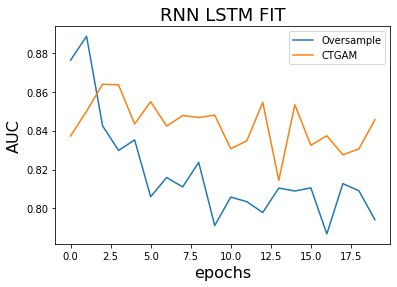

Oversample data based RNN LSTM Model - Test Data Performance
Accuracy:0.9917, AUC:0.7551, F1_Score:0.0366, Precision:0.044, Recall:0.033
CTGAN data based RNN LSTM Model - Test Data Performance
Accuracy:0.9867, AUC:0.7835, F1_Score:0.0421, Precision:0.0549, Recall:0.0366


In [148]:
# plot metrics
pyplot.plot(history.history['val_auc'], label = 'Oversample')
pyplot.xlabel('epochs',{'size':16})
pyplot.ylabel('AUC',{'size':16})


# plot metrics
pyplot.plot(history_ctgan.history['val_auc'],label = 'CTGAM')
pyplot.title('RNN LSTM FIT',{'size':18})

pyplot.legend(loc="upper right")
pyplot.show()

# evaluate model
loss, accuracy, tf.keras.metrics.AUC , f1_score, precision, recall = model.evaluate(x_test_o_reshape, y_test_reshape, batch_size=batch_size, verbose=0)

# print output
print(colored("Oversample data based RNN LSTM Model - Test Data Performance",'blue'))
print("Accuracy:{}, AUC:{}, F1_Score:{}, Precision:{}, Recall:{}".format(round(accuracy,4), round(tf.keras.metrics.AUC,4), round(f1_score,4), round(precision,4), round(recall,4)))

# evaluate model
loss_g, accuracy_g, tf.keras.metrics.AUC , f1_score_g, precision_g, recall_g = model.evaluate(x_test_ctgan_reshape, y_test_reshape, batch_size=batch_size, verbose=0)

# print output
from termcolor import colored
print(colored("CTGAN data based RNN LSTM Model - Test Data Performance", 'red'))
print("Accuracy:{}, AUC:{}, F1_Score:{}, Precision:{}, Recall:{}".format(round(accuracy_g,4),round(tf.keras.metrics.AUC,4), round(f1_score_g,4), round(precision_g,4), round(recall_g,4)))